# Analyzing Natural Gas Consumption: Trends, Seasonality, and Forecasting


Welcome to this data-driven exploration of natural gas consumption! As one of the most important energy sources worldwide, understanding trends in natural gas usage is critical for industries, policymakers, and energy markets.

In this project, we will analyze historical consumption data, uncover seasonal patterns, identify long-term trends, and build forecasting models to predict future demand. By leveraging tools like ETS models and advanced time series techniques, we aim to deliver meaningful insights into natural gas consumption behavior over time.

Let’s dive in and see what the data reveals! 🚀

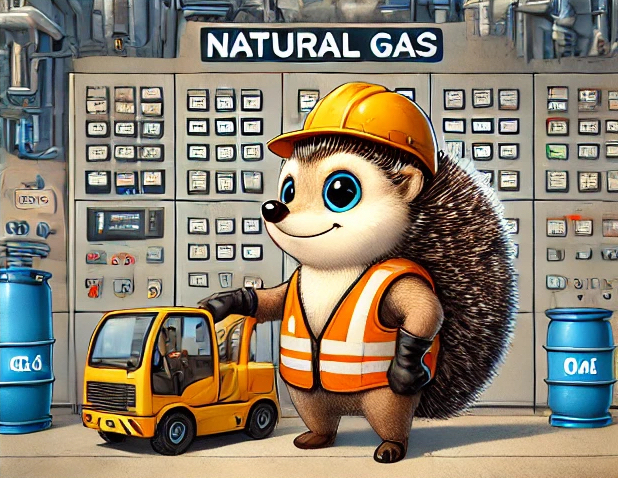

We took Monthly data on Natural Gas consumption in the US. The data is measured in Quadrillion Btu (British Thermal Unit). The data was taken from https://www.eia.gov/totalenergy/data/monthly/ - Independent Statistics and Analysis U.S. Energy Information Administration. Data starting point is the January of 1973. Our underlying assumption was seasonality of gas consumption, with peaks at winter periods due to heating seasons.




# Data Visualisation

In [ ]:
!pip install pandas matplotlib statsmodels

<ipython-input-1-b3f0a9388f4d>:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.resample('M').mean()


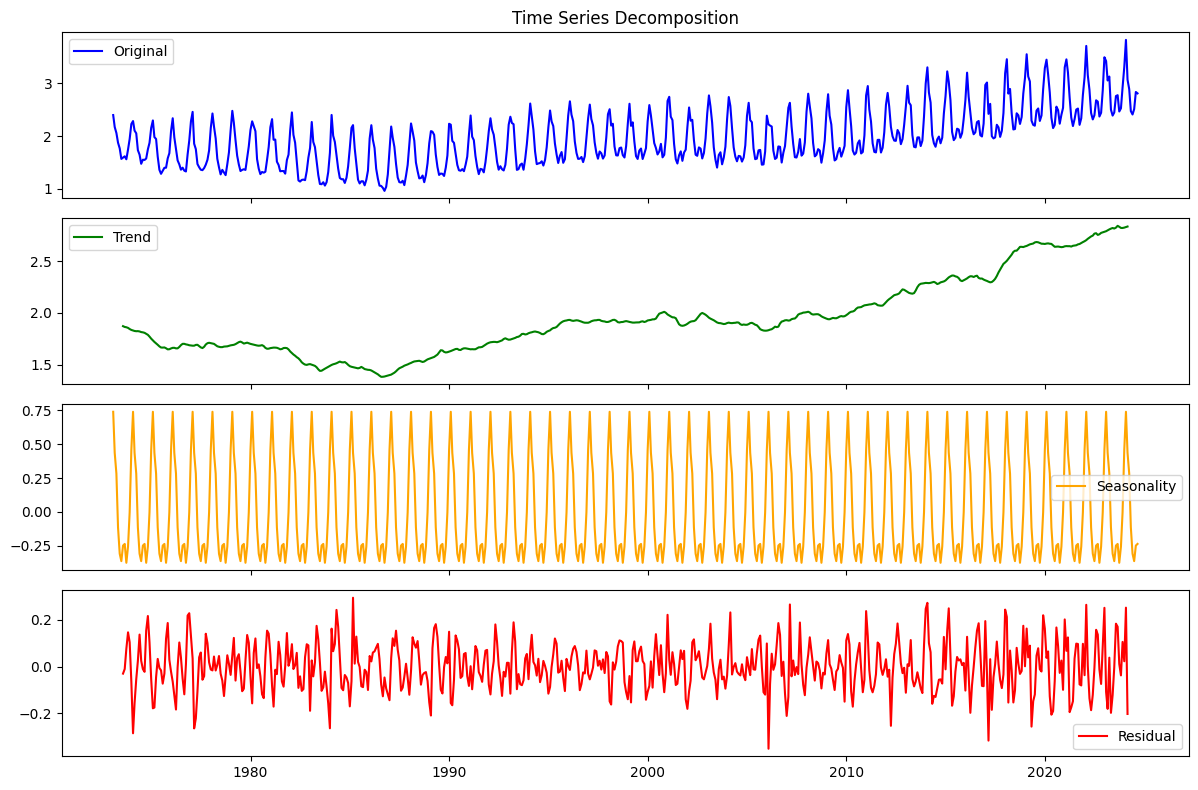

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

file_path = '/content/US Energy Natural Gas Data (2).csv'
data = pd.read_csv(file_path, sep=',', skip_blank_lines=True, skipinitialspace=True, header=None)

data.columns = ['Date', 'Price']

data['Price'] = data['Price'].str.replace(',', '.').astype(float)

data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y', errors='coerce')

data = data.dropna(subset=['Date', 'Price'])

data.set_index('Date', inplace=True)

data = data.resample('M').mean()

result = seasonal_decompose(data['Price'], model='additive', period=12)

fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

axes[0].plot(data, label='Original', color='blue')
axes[0].set_title('Time Series Decomposition')
axes[0].legend()

axes[1].plot(result.trend, label='Trend', color='green')
axes[1].legend()

axes[2].plot(result.seasonal, label='Seasonality', color='orange')
axes[2].legend()

axes[3].plot(result.resid, label='Residual', color='red')
axes[3].legend()

plt.tight_layout()
plt.show()

Brief Graph description:
Blue – original data plot. This graph shows the original time series data. We can observe a clear upward trend with seasonal patterns, that can be seen by regular periodic fluctuations.

Green graph - trend plot. Here we split the general data into trend dynamics. Trend component depicts the overall long-term direction of the time series data. It initially decreases slightly, remains stable for a period, and increases steadily throughout the whole observed period, particularly after the 2000s.

Orange graph - seasonal data The seasonal component highlights the repeating periodic patterns in the time series. Here and later we can visually observe winter hikes in consumption of gas. These patterns appear consistent with nearly constant frequency and amplitude throughout the observed period.

Red graph - residual plotThe residuals show the remaining variability after removing the trend and seasonal components. These fluctuations are irregular and indicate random noise in the data set. We can observe that residuals are distributed approximately normal, with expectation (mean) close to zero.

Now let's try to use an ETS model to decompose data, just for fun :)

<ipython-input-2-2c314140dd0c>:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.resample('M').mean()


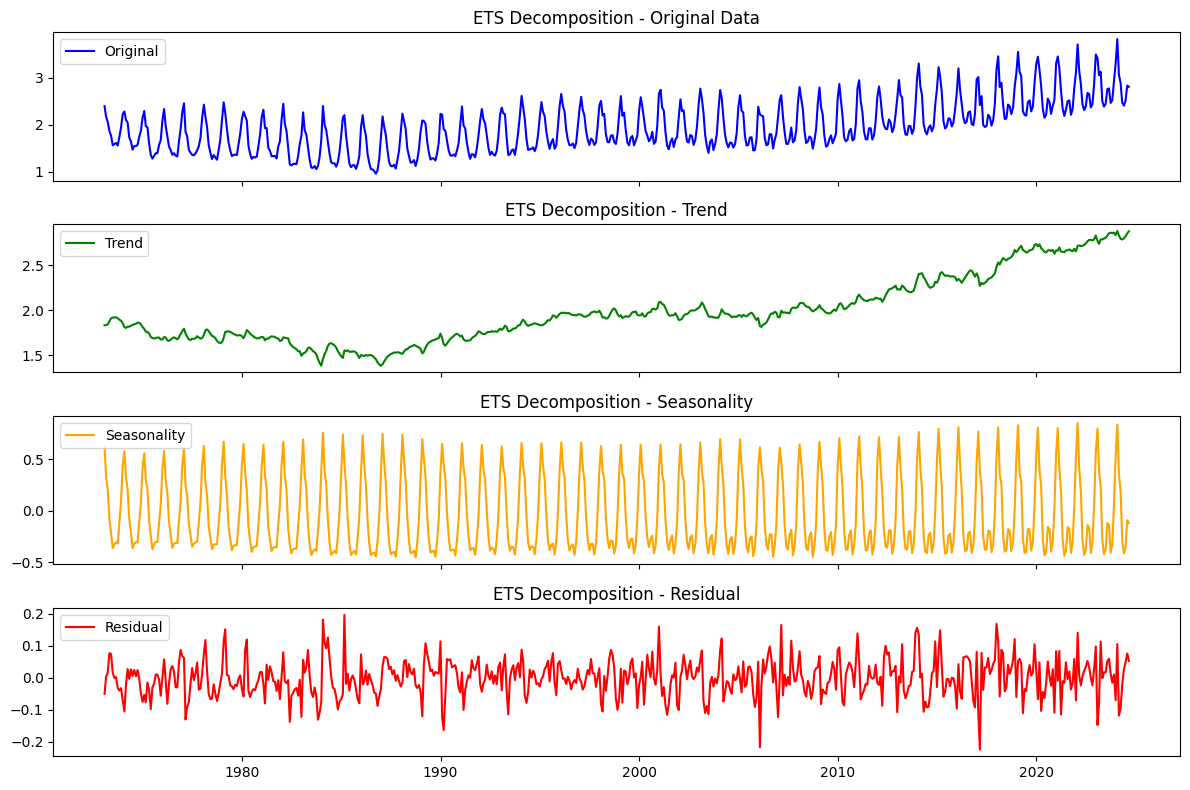

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

file_path = '/content/US Energy Natural Gas Data (2).csv'
data = pd.read_csv(file_path, sep=',', skip_blank_lines=True, skipinitialspace=True, header=None)

data.columns = ['Date', 'Price']

data['Price'] = data['Price'].str.replace(',', '.').astype(float)

data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y', errors='coerce')

data = data.dropna(subset=['Date', 'Price'])

data.set_index('Date', inplace=True)

data = data.resample('M').mean()

model = ExponentialSmoothing(
    data['Price'],
    seasonal='additive',
    trend='additive',
    seasonal_periods=12
).fit()

data['Trend'] = model.level
data['Seasonality'] = model.season
data['Residual'] = data['Price'] - data['Trend'] - data['Seasonality']

fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

axes[0].plot(data['Price'], label='Original', color='blue')
axes[0].set_title('ETS Decomposition - Original Data')
axes[0].legend()

axes[1].plot(data['Trend'], label='Trend', color='green')
axes[1].set_title('ETS Decomposition - Trend')
axes[1].legend()

axes[2].plot(data['Seasonality'], label='Seasonality', color='orange')
axes[2].set_title('ETS Decomposition - Seasonality')
axes[2].legend()

axes[3].plot(data['Residual'], label='Residual', color='red')
axes[3].set_title('ETS Decomposition - Residual')
axes[3].legend()

plt.tight_layout()
plt.show()

Blue Graph - Original Data.
This graph shows the original time series data, displaying a clear upward trend and consistent seasonal patterns. Compared to the previous graph, the patterns remain stable, but slight differences in seasonality may reflect minor adjustments in data behavior.

Green Graph - Trend Plot.
The trend component again depicts the overall long-term direction of the time series. Similar to the previous graph, the trend initially decreases slightly, stabilizes, and then increases steadily, particularly after the 2000s. The trend is smoother here, suggesting refined decomposition.

Orange Graph - Seasonal Data.
The seasonal component highlights repeating periodic patterns. As observed earlier, the seasonality appears consistent in frequency and amplitude. The patterns are more refined in this graph but align closely with those in the previous decomposition.

Red Graph - Residual Plot.
The residuals show the remaining variability after removing the trend and seasonal components. These fluctuations appear similar to the previous graph, showing irregular random noise with a mean close to zero. There are no significant differences in residual behavior.



First we will find the optimal number of trees using cross validation.

Here and after, we split our data set into two samples - training and testing, in proportion of 80/20. Our data sets covers monthly information starting from January 1973 and covers the time series until August of 2024. By proportion 80/20 we decided to use, our training data approximately lasts until 2013, and starting from 2014 we try to test and fit different statistical model to choose the option, which most accurately predict the values. Finally, we will compare MSE of different tests, to pick the most efficient one.

We separate the data between training and testing starting from point 3 and further in points 4,5

### **Why We Do Cross-Validation and How It Works**

---

### **Why We Do Cross-Validation**
- **Purpose**: Cross-validation is used to evaluate a model's performance and generalizability on unseen data.
- **Key Benefits**:
  - It prevents **overfitting** by ensuring the model is not just memorizing patterns in the training data.
  - It provides a more **reliable estimate** of the model's performance compared to a single train-test split.
  - It uses all available data efficiently by splitting it multiple times for training and testing.

---

### **How Cross-Validation Works**
- Cross-validation involves splitting the dataset into multiple subsets.  
- The model is trained on some folds and tested on the remaining folds. This process repeats for all folds, and the results are averaged.

#### **Steps**:
1. **Data Division**:  
   We Split the dataset into `k` folds.

2. **Iterative Training and Testing**:  
   - In each iteration, use `k-1` folds for training and the remaining fold for testing.
   - Rotate the test fold in each iteration so that all data gets used for testing once.

3. **Calculate Metrics**:  
   After all iterations,  the average performance metric is calculated, such as Mean Squared Error.

Lags: 1, Average MSE: 0.0462
Lags: 2, Average MSE: 0.0471
Lags: 3, Average MSE: 0.0534
Lags: 4, Average MSE: 0.0625
Lags: 5, Average MSE: 0.0636
Lags: 6, Average MSE: 0.0603
Lags: 7, Average MSE: 0.0617
Lags: 8, Average MSE: 0.0586
Lags: 9, Average MSE: 0.0592
Lags: 10, Average MSE: 0.0558
Lags: 11, Average MSE: 0.0379
Lags: 12, Average MSE: 0.0249

Optimal number of lags: 12 with MSE: 0.0249


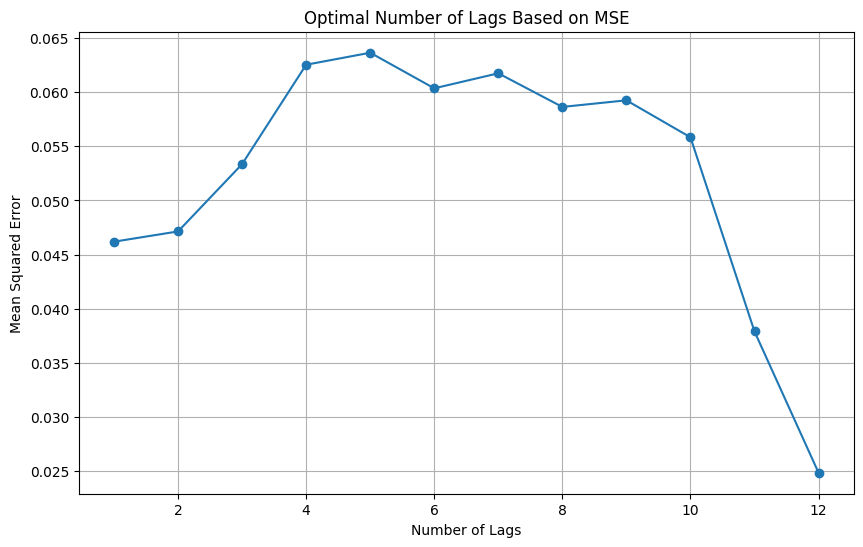

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

file_path = '/content/US Energy Natural Gas Data (2).csv'
data = pd.read_csv(file_path)

data.columns = ['Date', 'Consumption']
data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y')

data['Consumption'] = data['Consumption'].str.replace(',', '.').astype(float)


data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month


def find_optimal_lags(data, max_lags=12):
    results = []
    for lag in range(1, max_lags + 1):
        temp_data = data.copy()
        for i in range(1, lag + 1):
            temp_data[f'Lag_{i}'] = temp_data['Consumption'].shift(i)

        temp_data = temp_data.dropna()

        lag_features = [f'Lag_{i}' for i in range(1, lag + 1)]
        X = temp_data[['Year', 'Month'] + lag_features]
        y = temp_data['Consumption']

        tscv = TimeSeriesSplit(n_splits=5)
        mse_list = []
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)

            predictions = model.predict(X_test)
            mse = mean_squared_error(y_test, predictions)
            mse_list.append(mse)

        avg_mse = np.mean(mse_list)
        results.append((lag, avg_mse))
        print(f'Lags: {lag}, Average MSE: {avg_mse:.4f}')

    optimal_lag = min(results, key=lambda x: x[1])
    print(f"\nOptimal number of lags: {optimal_lag[0]} with MSE: {optimal_lag[1]:.4f}")
    return results

results = find_optimal_lags(data, max_lags=12)

lags, mses = zip(*results)
plt.figure(figsize=(10, 6))
plt.plot(lags, mses, marker='o')
plt.xlabel('Number of Lags')
plt.ylabel('Mean Squared Error')
plt.title('Optimal Number of Lags Based on MSE')
plt.grid()
plt.show()


### **Interpretation of Mean Squared Error (MSE)**

The output shows the **Mean Squared Error (MSE)** for different numbers of lag features. Here's the interpretation:

---

### **Trends**
- **Lags 1–3**:  
  The MSE increases slightly, indicating that adding 2–3 lags does not improve performance.  

- **Lags 4–10**:  
  The MSE stabilizes but remains relatively high, suggesting these lags don't add significant predictive power.  

- **Lags 11–12**:  
  The MSE drops notably, with **Lag 12** achieving the lowest value at **0.0249**.

---

### **Optimal Lag**
- **Lag 12** gives the **best performance** with the lowest MSE (**0.0249**).  
- This suggests that incorporating **12 months of past consumption** (a full year) helps the model capture **seasonal patterns** and long-term dependencies effectively.

---

### **Conclusion**
- The model performs best when **12 lag features** are included, likely due to the strong seasonality in natural gas consumption data.  
- Fewer lags (e.g., 1–10) miss this seasonality, leading to **higher errors**.


So, we build a tree with 12 lags.

Mean Squared Error: 0.04


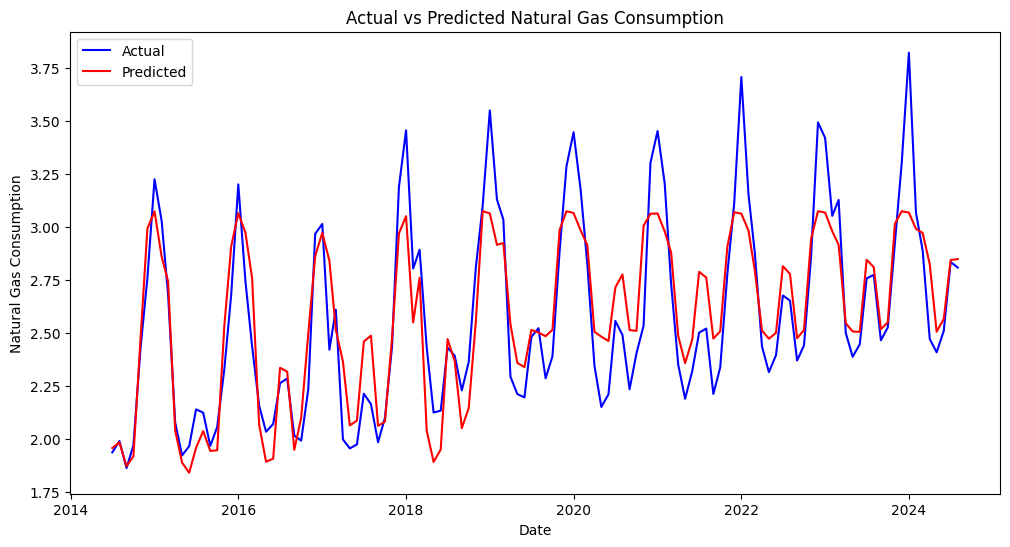

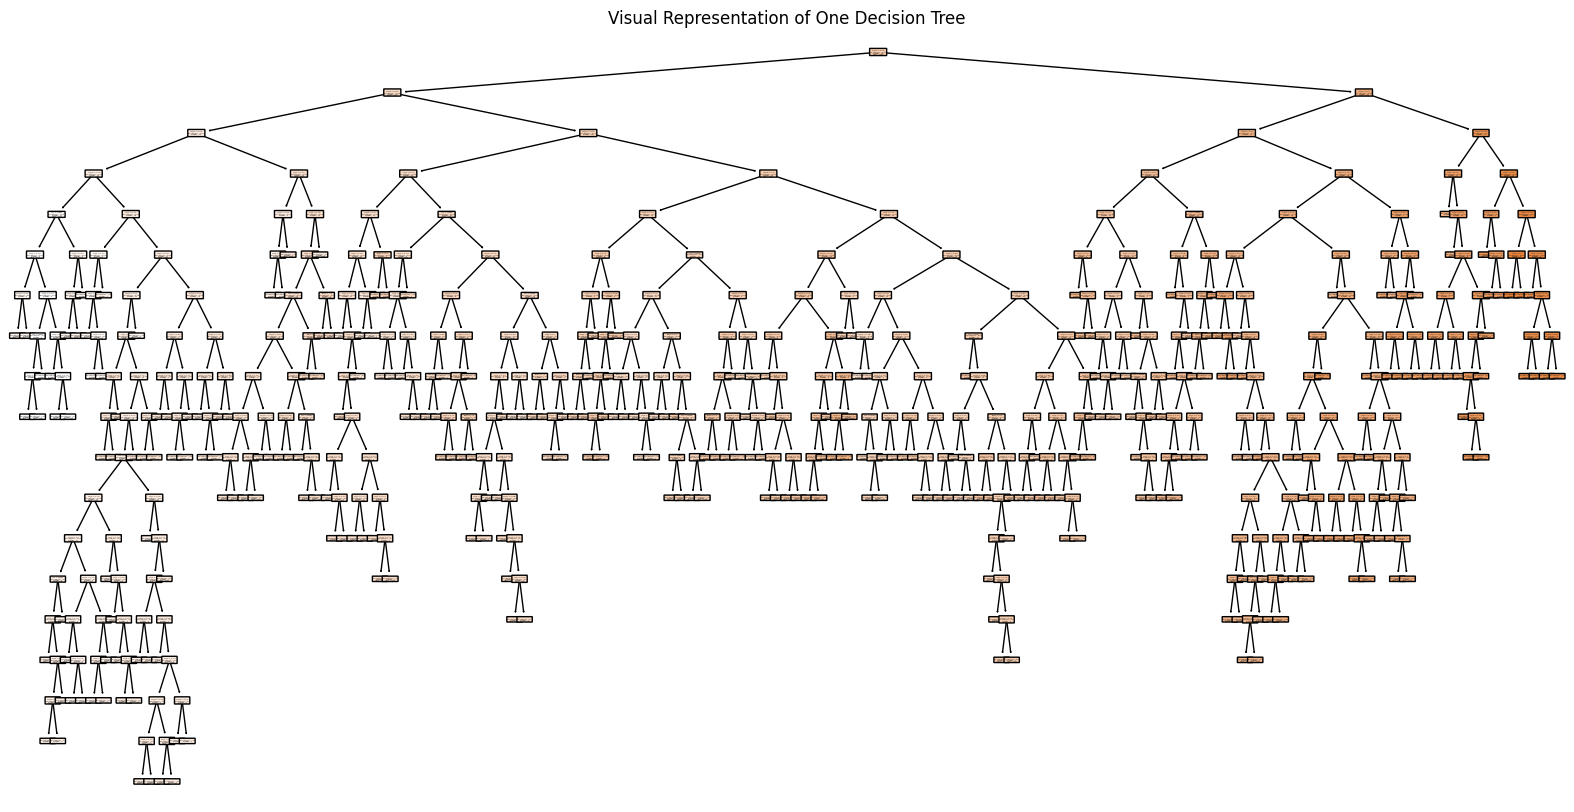

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

file_path = '/content/US Energy Natural Gas Data (2).csv'
data = pd.read_csv(file_path)

data.columns = ['Date', 'Consumption']
data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y')

data['Consumption'] = data['Consumption'].str.replace(',', '.').astype(float)

data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month

for lag in range(1, 13):
    data[f'Lag_{lag}'] = data['Consumption'].shift(lag)

data = data.dropna()

lag_features = [f'Lag_{i}' for i in range(1, 13)]
X = data[['Year', 'Month'] + lag_features]
y = data['Consumption']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(data['Date'].iloc[-len(y_test):], y_test, label='Actual', color='blue')
plt.plot(data['Date'].iloc[-len(y_test):], predictions, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Natural Gas Consumption')
plt.title('Actual vs Predicted Natural Gas Consumption')
plt.legend()
plt.show()

plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0], feature_names=X.columns, filled=True, rounded=True)
plt.title("Visual Representation of One Decision Tree")
plt.show()


# **Feature Creation and Code Explanation**

## **Features Created**
- **Year**: Extracted from the `Date` column to account for long-term trends in natural gas consumption over years.  
- **Month**: Extracted from the `Date` column to capture monthly and seasonal variations in the data.  
- **Lag_1 to Lag_12**: Consumption values from the previous 12 months are added as features. These lagged features help the model identify temporal dependencies and capture annual seasonality in natural gas consumption.  

---

## **Code Explanation**

### **Data Loading and Cleaning**
- The data is loaded and cleaned by:
  - Converting the `Date` column into a **datetime** format for easier manipulation.  
  - Replacing commas with dots in the `Consumption` column and converting it to a numeric format.

### **Feature Engineering**
Three types of features are created:
1. **Year** and **Month**: Capture long-term trends and seasonality.  
2. **Lag_1 to Lag_12**: Include consumption values from the past 12 months to model temporal dependencies.  

### **Handling Missing Values**
- Rows with missing values introduced by the lagged features are dropped to ensure data integrity.

---

### **Model Training**
- A **Random Forest Regressor** is used to predict natural gas consumption.  

#### **Why 100 Trees?**
- The model uses **100 trees** (`n_estimators=100`) to strike a balance between accuracy and computational efficiency.  
- A higher number of trees reduces variance in predictions and improves accuracy but increases training time.  

---

### **Evaluation**
- The **Mean Squared Error (MSE)** is calculated to evaluate the model's performance by comparing predicted and actual consumption values.

---

### **Visualization**
1. A plot is generated to compare the **actual vs predicted consumption** over the test set, providing a visual assessment of the model's performance.  
2. A visualization of a **single decision tree** from the Random Forest is included to help understand how the model splits the data for predictions.


### **Interpretation of MSE = 0.04**

1. **Error Scale**:
   - Given that consumption values are approximately **1.0–3.0**, an MSE of **0.04** indicates a small average squared error.
   - The square root of the MSE, **√0.04 = 0.2**, means that the predictions deviate from the actual values by about **0.2 units** on average.

2. **Relative Accuracy**:
   - A deviation of **0.2 units** is relatively small compared to the overall range of **1.0–3.0**.
   - This suggests that the model is performing **well** but still has slight inaccuracies, particularly during months with significant fluctuations.

3. **Practical Meaning**:
   - While the model is accurate, minor improvements could still be made, such as:
     - Adding additional predictors.
     - Fine-tuning hyperparameters

---

The model’s **MSE = 0.04** confirms it captures trends effectively and provides reliable predictions for monthly natural gas consumption.


In [ ]:
!pip install pandas matplotlib statsmodels

In [ ]:
!pip install sktime

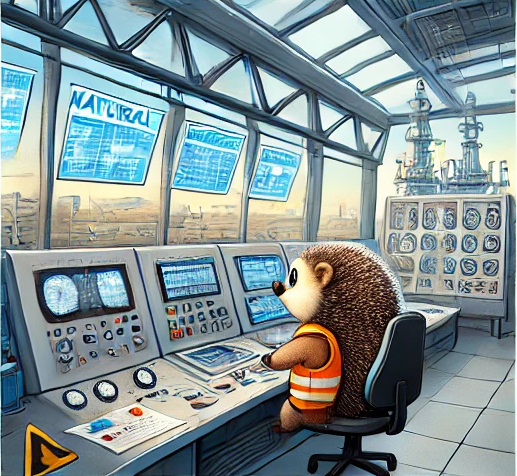

# ETS (Matvey)

In [ ]:
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.8/36.8 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.5/141.5 kB 9.1 MB/s eta 0:00:00


### Step 1:
In this step, we **load the dataset** using `pandas.read_csv()` and check its structure or content. We also visualise the orginal data.

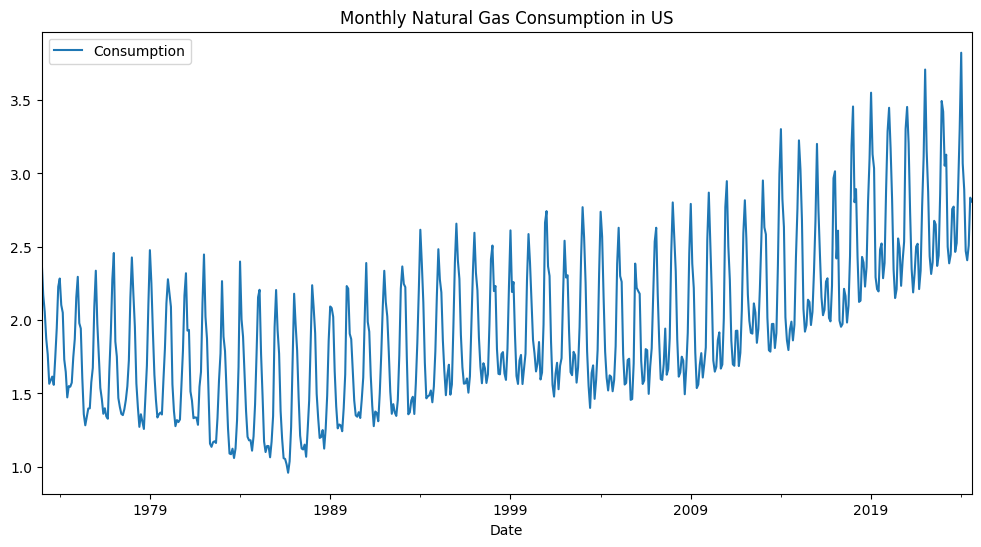

In [ ]:
import pandas as pd
import numpy as np
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt

file_path = "/content/US Energy Natural Gas Data (2).csv"  # Data
df = pd.read_csv(file_path)

df.columns = ["Date", "Consumption"]

df["Consumption"] = df["Consumption"].str.replace(",", ".").astype(float)

df["Date"] = pd.to_datetime(df["Date"], format="%d.%m.%Y")

df.set_index("Date", inplace=True)

df.sort_index(inplace=True)

df.plot(figsize=(12, 6), title="Monthly Natural Gas Consumption in US")
plt.show()

### Step 2:
Here, we **split the data** to train and test. Test is 20% of the data meaning everything after 2006. It may have some problems like outdated info, but we would like to use this method for consistency.

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


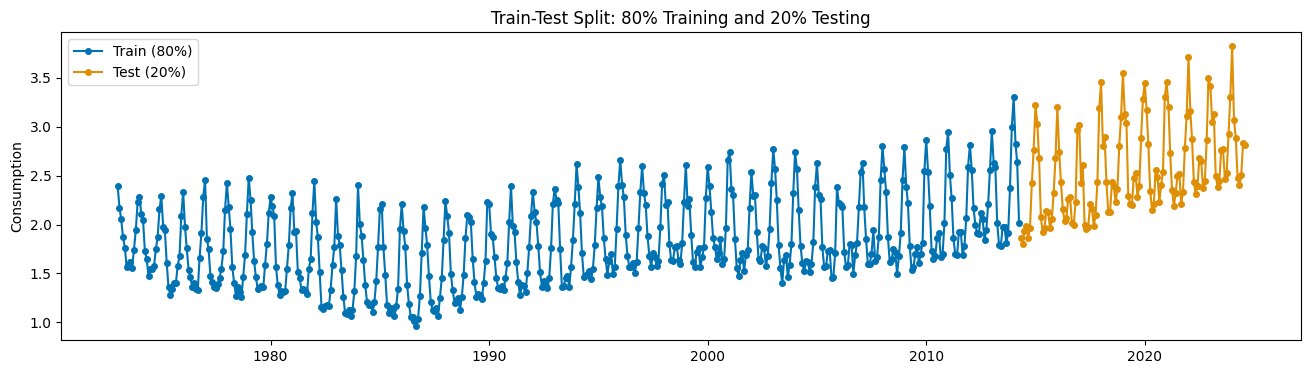

In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt

y = df["Consumption"]

test_size = int(0.2 * len(y))  # 20% of the total data length

y_train, y_test = temporal_train_test_split(y, test_size=test_size)

plot_series(y_train, y_test, labels=["Train (80%)", "Test (20%)"])
plt.title("Train-Test Split: 80% Training and 20% Testing")
plt.show()

### Step 3:
Here, we **make a prediciton** using ETS model. We convert the training and test indices to monthly periods for compatibility. The AutoETS model is initialized with automatic configuration and monthly seasonality. The model is trained on the training set, predictions are made for the test horizon, and results are plotted.

Training index type: <class 'pandas.core.indexes.period.PeriodIndex'>
Test index type: <class 'pandas.core.indexes.period.PeriodIndex'>


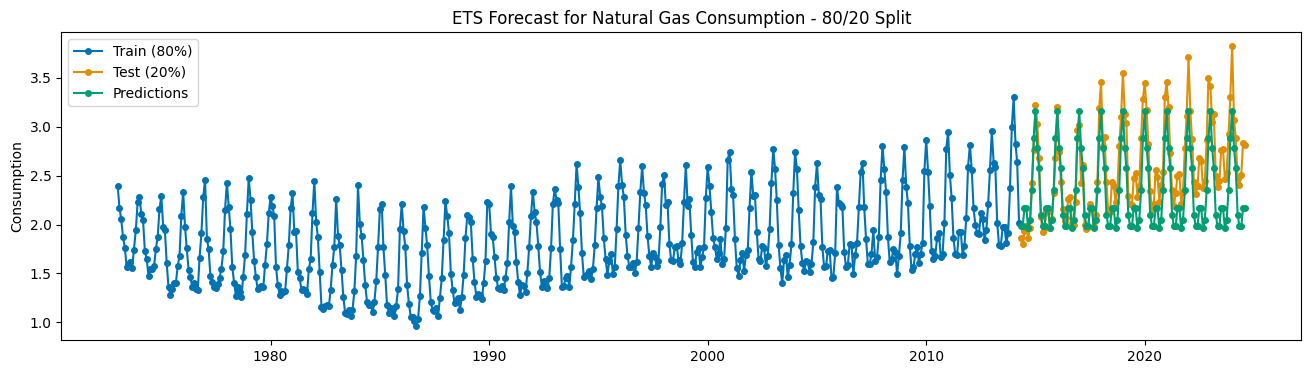

In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt

y = df["Consumption"]

test_size = int(0.2 * len(y))

y_train, y_test = temporal_train_test_split(y, test_size=test_size)

y_train_period = y_train.copy()
y_train_period.index = y_train_period.index.to_period("M")

y_test_period = y_test.copy()
y_test_period.index = y_test_period.index.to_period("M")

print(f"Training index type: {type(y_train_period.index)}")
print(f"Test index type: {type(y_test_period.index)}")

forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)
forecaster.fit(y_train_period)

fh = ForecastingHorizon(y_test_period.index, is_relative=False)

y_pred = forecaster.predict(fh)

plot_series(y_train_period, y_test_period, y_pred, labels=["Train (80%)", "Test (20%)", "Predictions"])
plt.title("ETS Forecast for Natural Gas Consumption - 80/20 Split")
plt.show()

### Step 4:
Here is a better visual of the prediction focusing only on the last 5 years:

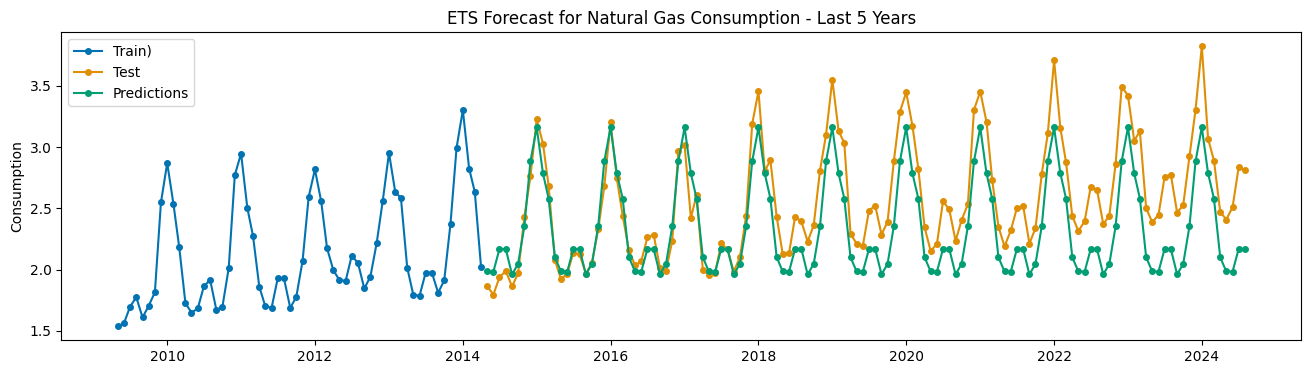

In [ ]:
latest_months = 60 # Lastt 5 years
y_train_latest = y_train_period[-latest_months:]
y_test_latest = y_test_period
y_pred_latest = y_pred

plot_series(
    y_train_latest,
    y_test_latest,
    y_pred_latest,
    labels=["Train)", "Test", "Predictions"]
)
plt.title(f"ETS Forecast for Natural Gas Consumption - Last 5 Years")
plt.show()

### Step 5:
Now, we evaluate the performance of our forecasting. MAE gives 0.26 which is good considering that consumption of natural gas are between 2 and 3.75 BTU.

In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

from sklearn.metrics import mean_squared_error

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")

Mean Absolute Error (MAE): 0.2645
Mean Squared Error (MSE): 0.0998


### Step 6:
However, we would like to have a more precise evaluation, so we used MAPE for further evaluation. We got 9.97% which is acceptible. The issue is that trend for gas consumption increased after 2006 which was not caught by the forecasting, since this trend changed in test.

In [ ]:
y_test_aligned = y_test_period.to_numpy()
y_pred_aligned = y_pred.to_numpy()

mape = np.mean(np.abs((y_test_aligned - y_pred_aligned) / y_test_aligned)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 9.97%


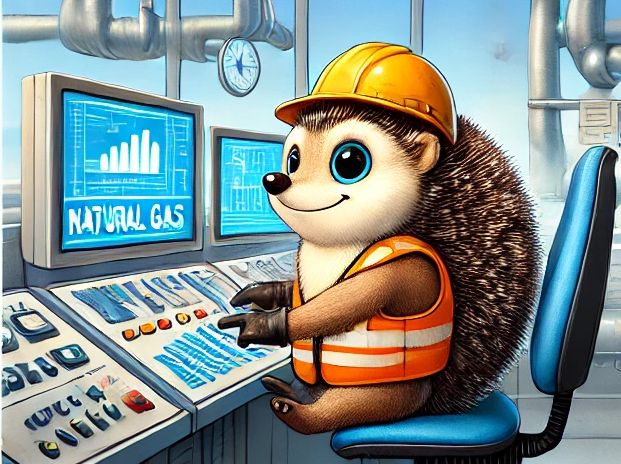

# SARIMA Method


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Mean Squared Error: 0.0170


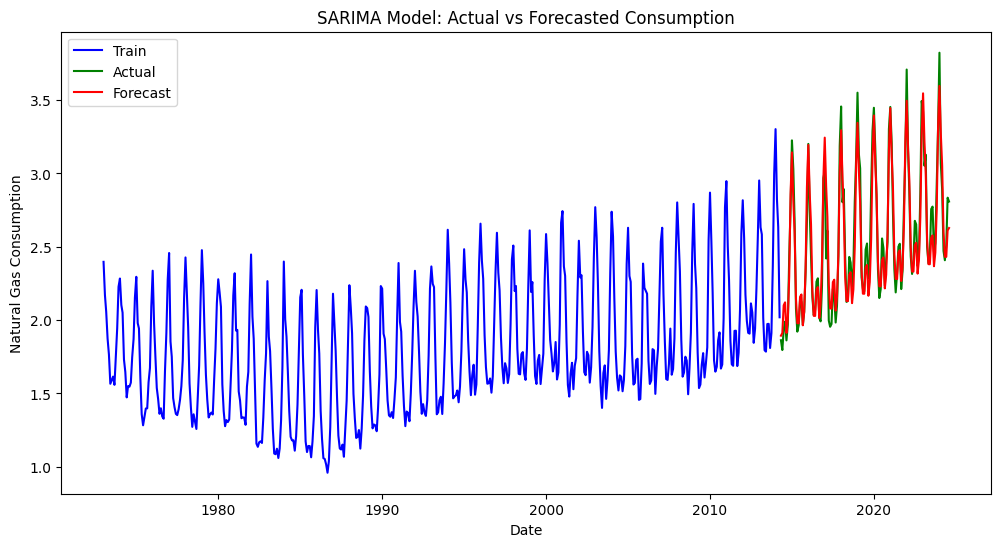

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

file_path = '/content/US Energy Natural Gas Data (2).csv'
data = pd.read_csv(file_path)

data.columns = ['Date', 'Consumption']
data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y')

data['Consumption'] = data['Consumption'].str.replace(',', '.').astype(float)

data.set_index('Date', inplace=True)

train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Fit SARIMA model
# Define SARIMA parameters: (p, d, q)(P, D, Q, s)
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12

model = SARIMAX(train['Consumption'], order=(p, d, q), seasonal_order=(P, D, Q, s), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)

forecast = model_fit.forecast(steps=len(test))

mse = mean_squared_error(test['Consumption'], forecast)
print(f"Mean Squared Error: {mse:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Consumption'], label='Train', color='blue')
plt.plot(test.index, test['Consumption'], label='Actual', color='green')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Natural Gas Consumption')
plt.title('SARIMA Model: Actual vs Forecasted Consumption')
plt.legend()
plt.show()


This graph compares actual and forecasted natural gas consumption using a SARIMA model. The blue line represents the training data, the green line shows the actual data for the test period, and the red line displays the forecasted values. The forecast closely follows the actual data, capturing both the increasing trend and seasonal fluctuations, although slight deviations occur in some periods.

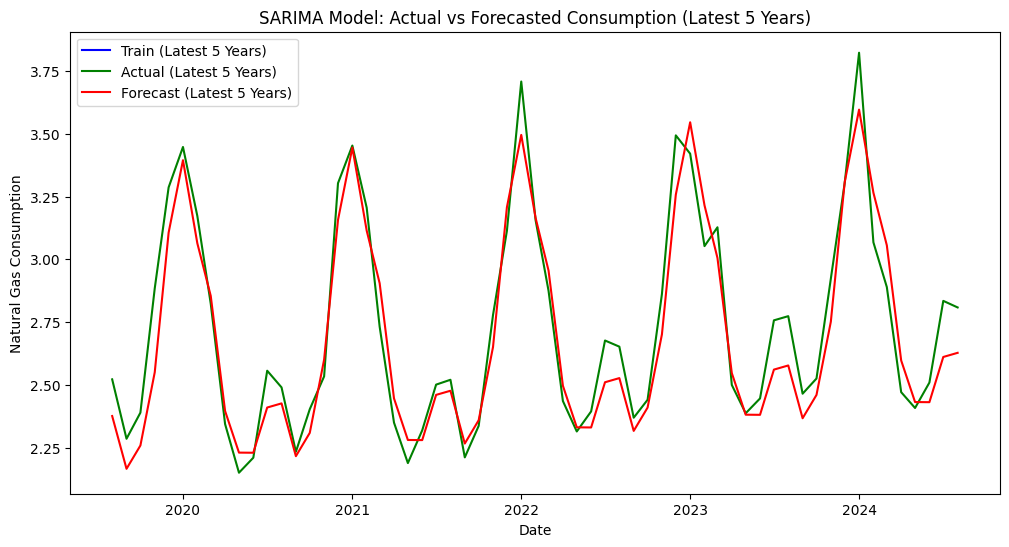

In [ ]:
latest_5_years_start = test.index[-1] - pd.DateOffset(years=5)
train_latest = train[train.index >= latest_5_years_start]
test_latest = test[test.index >= latest_5_years_start]
forecast_latest = forecast[forecast.index >= latest_5_years_start]

plt.figure(figsize=(12, 6))
plt.plot(train_latest.index, train_latest['Consumption'], label='Train (Latest 5 Years)', color='blue')
plt.plot(test_latest.index, test_latest['Consumption'], label='Actual (Latest 5 Years)', color='green')
plt.plot(test_latest.index, forecast_latest, label='Forecast (Latest 5 Years)', color='red')
plt.xlabel('Date')
plt.ylabel('Natural Gas Consumption')
plt.title('SARIMA Model: Actual vs Forecasted Consumption (Latest 5 Years)')
plt.legend()
plt.show()

This graph focuses on the latest 5 years of the prediction period, comparing actual and forecasted natural gas consumption. The green line represents the actual values, while the red line shows the SARIMA model's forecasts, with the blue line marking the end of the training period. The forecasted values closely follow the actual data, effectively capturing both seasonal peaks and troughs.

### **How the SARIMA Model Works**

---

### **1. Overview of SARIMA**  
SARIMA stands for **Seasonal AutoRegressive Integrated Moving Average**. It is an extension of the ARIMA model that accounts for both **trend** and **seasonality** in time series data. The model uses the following components:

- **(p, d, q)**: ARIMA parameters  
   - **p (AutoRegressive order)**: Number of past values (lags) the model uses to predict the current value.  
   - **d (Differencing order)**: Number of times the data is differenced to remove trends and make it stationary.  
   - **q (Moving Average order)**: Number of past forecast errors used in the model.  

- **(P, D, Q, s)**: Seasonal parameters  
   - **P**: Seasonal autoregressive order.  
   - **D**: Seasonal differencing order.  
   - **Q**: Seasonal moving average order.  
   - **s**: Seasonal period (e.g., 12 for monthly data to capture yearly seasonality).  

---

### **2. Steps in the Code**

1. **Data Preparation**:
   - The data is preprocessed by converting dates to a `datetime` format and setting the `Date` column as the index.
   - The data is split into **training** (80%) and **testing** (20%) sets, ensuring the temporal order is preserved.

2. **Model Configuration**:
   - The SARIMA model is defined with the parameters **(p, d, q) = (1, 1, 1)** and **(P, D, Q, s) = (1, 1, 1, 12)**.  
   - These parameters are chosen to model both the short-term dependencies (ARIMA part) and the annual seasonality (seasonal component with `s=12`).

3. **Training the Model**:
   - The SARIMA model is fit on the training dataset, where it learns the relationships between past values, trends, and seasonality.

4. **Forecasting**:
   - The model predicts the next **steps** equal to the size of the test set.  
   - Forecasted values are compared to the actual values in the test set.

5. **Evaluation**:
   - Model accuracy is evaluated using **Mean Squared Error (MSE)**, which quantifies the average squared difference between the forecasted and actual values.

6. **Visualization**:
   - A plot is generated showing:
     - **Training Data** (blue): Historical data used for training.  
     - **Actual Data** (green): Ground-truth values from the test set.  
     - **Forecasted Data** (red): Model predictions for the test set.

---

### **3. Why It Works**
- SARIMA effectively combines autoregression, differencing, and moving averages to capture **trends** and **seasonal patterns**.  
- By incorporating lagged values and seasonal adjustments, the model can make accurate predictions for periodic data like **monthly natural gas consumption**.

---


# Conclusion

### **Conclusion: Comparison of Forecasting Approaches**

In this analysis, we compared three forecasting methods—**Random Forest**, **ETS**, and **SARIMA**—based on their **Mean Squared Error (MSE)** on the test set. Below are the results and explanations for their performance:

---

1. **Random Forest**:  
   - Using cross-validation, we identified **12 lags** as the optimal feature set, which allowed the model to effectively capture short-term dependencies and annual seasonality in the data.  
   - The model achieved an **MSE of 0.04**, which indicates strong predictive performance.  
   - **Why it performed well**: Random Forest is robust to overfitting, handles non-linear relationships effectively, and benefits from lag features that account for temporal dependencies.  
   - **Why it was not the best**: Random Forest does not explicitly model seasonality or trends, which may limit its performance compared to models specifically designed for time series.

---

2. **ETS (Error, Trend, Seasonality)**:  
   - The ETS model produced an **MSE of 0.09**, which is higher than both the Random Forest and SARIMA models.  
   - **Why it underperformed**: While ETS models are designed to handle trend and seasonality components, they assume a relatively simple structure for the data and may not fully capture the complex dependencies and variability in natural gas consumption.  
   - This resulted in less accurate forecasts compared to methods that account for both non-linearity (Random Forest) and seasonal patterns (SARIMA).

---

3. **SARIMA**:  
   - The SARIMA model, with seasonal and autoregressive components, achieved the **lowest MSE of 0.0170**.  
   - **Why it performed best**: SARIMA explicitly models both **seasonal patterns** (e.g., yearly seasonality) and **short-term temporal dependencies**, making it highly effective for data with strong seasonal trends like monthly natural gas consumption.  
   - By incorporating both differencing and seasonal adjustments, SARIMA successfully minimized the forecast error.

---

### **Best Approach**  
The **SARIMA model** is the best approach for forecasting natural gas consumption, as it achieved the **lowest error (MSE = 0.0170)** on the test set. Its ability to model both **short-term trends** and **seasonality** gives it a significant advantage over Random Forest and ETS methods.  

- Random Forest, while strong, did not explicitly account for seasonality.  
- ETS, on the other hand, oversimplified the data structure, resulting in higher forecast errors.

---

In conclusion, SARIMA’s ability to combine seasonal components with autoregressive features makes it the most accurate and suitable model for this time series data.